In [1]:
import pandas as pd
import matplotlib.pyplot as plt
# 读取污染物浓度数据（附件1）和气象数据（附件2）
pollution_data = pd.read_excel("附件1：污染物浓度数据.xlsx", engine="openpyxl")
weather_data = pd.read_excel("附件2：气象数据.xlsx", engine="openpyxl")

# # 将质量等级转换为数值型数据（独热编码）
# all_categories = ['优', '良', '轻度污染', '中度污染', '重度污染', '严重污染']
# pollution_data['质量等级'] = pd.Categorical(pollution_data['质量等级'], categories=all_categories)
# pollution_data = pd.concat([pollution_data, pd.get_dummies(pollution_data["质量等级"])], axis=1)
# pollution_data.drop("质量等级", axis=1, inplace=True)

# 合并数据集
merged_data = pollution_data.merge(weather_data, left_on=["year", "month", "day"], right_on=["V04001", "V04002", "V04003"])

# 移除不需要的列
#merged_data.drop(["年", "month", "日", "V04001", "V04002", "V04003", "V01301","质量等级","AQI"], axis=1, inplace=True)
merged_data.drop(["V04001", "V04002", "V04003", "V01301","质量等级"], axis=1, inplace=True)

# 删除包含缺失值的行
merged_data.dropna(axis=0, inplace=True)

merged_data.to_csv("unprocessed_data.csv", index=False, encoding="utf-8")

查看各个数据的大体趋势

数据预处理：运用回归插补方法

In [2]:
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

def remove_outliers_iqr(df):
    Q1 = df.quantile(0.01)
    Q3 = df.quantile(0.99)
    return df[(df > Q1) & (df < Q3)]

temp_year = merged_data['year'].copy()
temp_month = merged_data['month'].copy()
temp_day = merged_data['day'].copy()
# 移除异常值
merged_data_no_outliers = remove_outliers_iqr(merged_data)

# 将缺失值替换为NaN
merged_data_no_outliers.replace(to_replace={col: {value: np.nan for value in merged_data_no_outliers[col].unique() if pd.isna(value)} for col in merged_data_no_outliers.columns}, inplace=True)

# 使用回归插补填充缺失值
imputer = IterativeImputer(random_state=42, max_iter=50)
imputed_data = imputer.fit_transform(merged_data_no_outliers)

# 将结果转换回DataFrame
imputed_data_df = pd.DataFrame(imputed_data, columns=merged_data_no_outliers.columns)
# 将之前保存的 'month' 列添加回 imputed_data_df
imputed_data_df['year'] = temp_year.values
imputed_data_df['month'] = temp_month.values
imputed_data_df['day'] = temp_day.values

这是用k-NN去噪算法的代码，但是效果并不理想

# 用皮尔逊系数简单直观的看每个数据之间的关系

In [3]:
# Set the dividing point as the 80% mark
dividing_point = int(len(imputed_data_df) * 0.8)

# Split the data into training and testing sets
train_data = imputed_data_df[:dividing_point]
test_data = imputed_data_df[dividing_point:]

# Save the training and testing sets as CSV files
train_data.to_csv("train_data.csv", index=False, encoding="utf-8")
test_data.to_csv("test_data.csv", index=False, encoding="utf-8")


# 模型训练

In [4]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np

# 特征矩阵X，我们从merged_data中删除PM2.5列
X_train = train_data.drop("PM2.5", axis=1)
# 目标向量y，即PM2.5值
y_train = train_data["PM2.5"]

X_test = test_data.drop("PM2.5", axis=1)
y_test = test_data["PM2.5"]

#创建随机森林模型
rf = RandomForestRegressor(n_estimators=100, random_state=43)
#训练模型
rf.fit(X_train, y_train)
#使用模型预测测试集
y_pred = rf.predict(X_test)
#计算模型的均方根误差（RMSE）
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE:", rmse)

#输出特征重要性
#feature_importances = rf.feature_importances_
#for feature, importance in zip(X_train.columns, feature_importances):
#    print(f"{feature}: {importance}")

feature_names = list(X_train.columns)

# 获取特征名称和对应的重要性值
feature_importances = list(zip(feature_names, rf.feature_importances_))

# 对特征重要性进行降序排序
sorted_feature_importances = sorted(feature_importances, key=lambda x: x[1], reverse=True)

# 输出排序后的特征名称和重要性值
for feature, importance in sorted_feature_importances:
    print(f"Feature: {feature}, Importance: {importance}")


RMSE: 5.823712249874142
Feature: PM10, Importance: 0.6045884725862452
Feature: AQI, Importance: 0.26428005968520646
Feature: V12001_700, Importance: 0.0586481295719593
Feature: CO, Importance: 0.02379865122666031
Feature: O3, Importance: 0.020767004782020888
Feature: V13003_700, Importance: 0.006231909163314702
Feature: NO2, Importance: 0.00472403176210868
Feature: V10004_700, Importance: 0.0034807220195088194
Feature: V13305, Importance: 0.0026111814351713236
Feature: V11291_700, Importance: 0.002603977654311248
Feature: year, Importance: 0.0024824701400019775
Feature: day, Importance: 0.0021789390699695817
Feature: SO2, Importance: 0.0021022022614967414
Feature: month, Importance: 0.0015022486420247908


In [5]:
print(imputed_data_df['PM2.5'])

0        46.0
1        83.0
2       110.0
3       133.0
4       153.0
        ...  
3030     19.0
3031     19.0
3032     26.0
3033     32.0
3034     45.0
Name: PM2.5, Length: 3035, dtype: float64


# 第二小问

用随机森林的原函数用不了，改用别的方法

In [6]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

进行归一化处理

In [7]:
print(imputed_data_df['PM2.5'])

0        46.0
1        83.0
2       110.0
3       133.0
4       153.0
        ...  
3030     19.0
3031     19.0
3032     26.0
3033     32.0
3034     45.0
Name: PM2.5, Length: 3035, dtype: float64


In [8]:
#选择需要归一化的列，并将其转换为NumPy数组：
columns_to_normalize = ['PM10', 'CO', 'V12001_700','NO2', 'O3', 'AQI', 'year', 'month', 'day',]  # 使用你需要归一化的列名替换这里的列名
imputed_data_df_static = imputed_data_df.copy()
data_values = imputed_data_df[columns_to_normalize].values

#创建MinMaxScaler对象，并用训练集数据拟合它：
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(data_values)  # 使用你的数据拟合scaler

#使用拟合好的scaler对数据进行转换：
data_normalized = scaler.transform(data_values)
#将归一化后的数据替换到原始DataFrame中：
imputed_data_df[columns_to_normalize] = data_normalized

创建一个副本，该副本内的所有数据都进行了归一化

In [9]:
all_data_values = imputed_data_df_static.values
#创建MinMaxScaler对象，并用训练集数据拟合它：
scaler_all = MinMaxScaler(feature_range=(0, 1))
scaler_all.fit(all_data_values)  # 使用你的数据拟合scaler

#使用拟合好的scaler对数据进行转换：
data_normalized = scaler_all.transform(all_data_values)
#将归一化后的数据替换到原始DataFrame中：
imputed_data_df_static = data_normalized

In [10]:
print(imputed_data_df.shape[0])

3035


In [11]:
# 创建一个新的MinMaxScaler实例，专门用于目标变量
scaler_y = MinMaxScaler()

target_values = imputed_data_df['PM2.5']
# 将目标变量（例如，PM2.5浓度）转换为 NumPy 数组
target_values_np = np.array(target_values)
# 将目标变量重塑为2D数组，以便适应scaler_y
target_values_np = target_values_np.reshape(-1, 1)

# 使用scaler_y拟合目标变量，并执行归一化
normalized_target_values = scaler_y.fit_transform(target_values_np)
imputed_data_df['PM2.5'] = normalized_target_values

In [12]:
print(imputed_data_df['PM2.5'])

0       0.272152
1       0.506329
2       0.677215
3       0.822785
4       0.949367
          ...   
3030    0.101266
3031    0.101266
3032    0.145570
3033    0.183544
3034    0.265823
Name: PM2.5, Length: 3035, dtype: float64


时间序列数据转换为滑动窗口形式的监督学习问题

In [13]:
#定义一个函数，用于将数据转换为LSTM所需的格式：
def create_dataset(dataset, look_back=1):
    data_x, data_y = [], []
    for i in range(len(dataset) - look_back):
        data_x.append(dataset[i:(i + look_back), :])
        data_y.append(dataset[i + look_back, 4])  #  PM2.5 是第5列（索引为4）
    return np.array(data_x), np.array(data_y)

imputed_data_df.drop(["month", "SO2", "day", "V11291_700", "V13305", "V10004_700", "NO2" ,"V13003_700"], axis=1, inplace=True)
look_back = 14  # 更改此值以设置窗口大小
ques2_data_values = imputed_data_df.values  # 从DataFrame中提取值
ques2_data_x, ques2_data_y = create_dataset(ques2_data_values, look_back)

#将数据划分为训练集和测试集(我们将20%的数据保留为测试集)：
#不应对时间序列数据进行随机抽样，因此将shuffle参数设置为False
ques2_train_x, ques2_test_x, ques2_train_y, ques2_test_y = train_test_split(ques2_data_x, ques2_data_y, test_size=0.1, shuffle=False)

model = Sequential()
model.add(LSTM(50, input_shape=(ques2_train_x.shape[1], ques2_train_x.shape[2])))  # 50 个 LSTM 单元
model.add(Dense(1))  # 输出层，1 个神经元，用于预测 PM2.5
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(ques2_train_x, ques2_train_y, epochs=100, batch_size=32, validation_data=(ques2_test_x, ques2_test_y), verbose=2, shuffle=False)


Epoch 1/100
85/85 - 2s - loss: 0.0202 - val_loss: 0.0144 - 2s/epoch - 26ms/step
Epoch 2/100
85/85 - 0s - loss: 0.0165 - val_loss: 0.0129 - 379ms/epoch - 4ms/step
Epoch 3/100
85/85 - 0s - loss: 0.0144 - val_loss: 0.0120 - 321ms/epoch - 4ms/step
Epoch 4/100
85/85 - 0s - loss: 0.0138 - val_loss: 0.0115 - 343ms/epoch - 4ms/step
Epoch 5/100
85/85 - 0s - loss: 0.0129 - val_loss: 0.0110 - 329ms/epoch - 4ms/step
Epoch 6/100
85/85 - 0s - loss: 0.0124 - val_loss: 0.0107 - 417ms/epoch - 5ms/step
Epoch 7/100
85/85 - 0s - loss: 0.0121 - val_loss: 0.0106 - 337ms/epoch - 4ms/step
Epoch 8/100
85/85 - 0s - loss: 0.0119 - val_loss: 0.0107 - 336ms/epoch - 4ms/step
Epoch 9/100
85/85 - 0s - loss: 0.0119 - val_loss: 0.0108 - 286ms/epoch - 3ms/step
Epoch 10/100
85/85 - 0s - loss: 0.0117 - val_loss: 0.0106 - 332ms/epoch - 4ms/step
Epoch 11/100
85/85 - 0s - loss: 0.0116 - val_loss: 0.0105 - 365ms/epoch - 4ms/step
Epoch 12/100
85/85 - 0s - loss: 0.0115 - val_loss: 0.0104 - 337ms/epoch - 4ms/step
Epoch 13/100
85

Epoch 100/100
85/85 - 0s - loss: 0.0099 - val_loss: 0.0112 - 289ms/epoch - 3ms/step


这段代码将绘制模型在每个训练周期中的训练损失和验证损失。通过查看损失曲线，我们可以判断模型是否过拟合或欠拟合，并据此调整模型参数。

对测试集进行预测并计算预测结果的RMSE

In [14]:
# 预测测试集数据
predicted_test_y = model.predict(ques2_test_x)

# 反归一化预测结果
predicted_test_y = scaler_y.inverse_transform(predicted_test_y)

# 将目标变量（例如，PM2.5浓度）转换为 NumPy 数组
ques2_test_values_np = np.array(ques2_test_y)
# 将目标变量重塑为2D数组，以便适应scaler_y
ques2_test_values_np = ques2_test_values_np.reshape(-1, 1)
# 反归一化真实值
real_test_y = scaler_y.inverse_transform(ques2_test_values_np)

# 计算预测结果的 RMSE
rmse = np.sqrt(mean_squared_error(real_test_y, predicted_test_y))
print(f"Test RMSE: {rmse}")


10/10 [==============================] - 0s 2ms/step
Test RMSE: 16.68664182357304


In [15]:
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.optimizers import Adam


# 假设已经完成了数据准备和归一化
# X_train, y_train, X_test, y_test
#将数据划分为训练集和测试集(我们将20%的数据保留为测试集)：
#不应对时间序列数据进行随机抽样，因此将shuffle参数设置为False
data_train_multistep, data_test_multistep = train_test_split(imputed_data_df, test_size=0.05, shuffle=False)
data_train_multistep = data_train_multistep.values
data_test_multistep = data_test_multistep.values

multistep_look_back = 12 # 输入窗口大小
num_steps = 12 # 预测的天数

# # 修改目标值数组，使其包含连续的多个PM2.5值
# def create_multistep_targets(data, look_back, num_steps):
#     multistep_targets = []
#     for i in range(len(data) - look_back - num_steps + 1):
#         multistep_targets.append(data[i + look_back: i + look_back + num_steps])
#     return np.array(multistep_targets)
def create_multistep_dataset(data, look_back, num_steps):
    data_x, data_y = [], []
    for i in range(len(data) - look_back - num_steps):
        data_x.append(data[i:i + look_back, :])
        data_y.append(data[i + look_back:i + look_back + num_steps, 4])  # Assuming PM2.5 is the 4th column
    return np.array(data_x), np.array(data_y)

multistep_train_x, multistep_train_y = create_multistep_dataset(data_train_multistep, multistep_look_back, num_steps)
multistep_test_x, multistep_test_y = create_multistep_dataset(data_test_multistep, multistep_look_back, num_steps)

# 创建LSTM模型
multistep_model = Sequential()
multistep_model.add(LSTM(50, activation='relu', input_shape=(multistep_look_back, multistep_train_x.shape[2])))
multistep_model.add(Dense(num_steps))
multistep_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# 训练模型
multistep_model.fit(multistep_train_x, multistep_train_y, epochs=100, batch_size=32, verbose=1)

# 预测
y_pred_multistep = multistep_model.predict(multistep_test_x)

#对预测结果进行逆归一化（如果需要）
y_pred_multistep = scaler_y.inverse_transform(y_pred_multistep)
multistep_test_y = scaler_y.inverse_transform(multistep_test_y)
history_multistep = multistep_model.fit(multistep_train_x, multistep_train_y, epochs=100, batch_size=32, validation_data=(multistep_test_x, multistep_test_y), verbose=2, shuffle=False)


Epoch 1/100
90/90 [==============================] - 1s 4ms/step - loss: 0.0380
Epoch 2/100
90/90 [==============================] - 0s 3ms/step - loss: 0.0196
Epoch 3/100
90/90 [==============================] - 0s 4ms/step - loss: 0.0183
Epoch 4/100
90/90 [==============================] - 0s 3ms/step - loss: 0.0179
Epoch 5/100
90/90 [==============================] - 0s 3ms/step - loss: 0.0174
Epoch 6/100
90/90 [==============================] - 0s 3ms/step - loss: 0.0170
Epoch 7/100
90/90 [==============================] - 0s 3ms/step - loss: 0.0170
Epoch 8/100
90/90 [==============================] - 0s 3ms/step - loss: 0.0169
Epoch 9/100
90/90 [==============================] - 0s 3ms/step - loss: 0.0170
Epoch 10/100
90/90 [==============================] - 0s 4ms/step - loss: 0.0169
Epoch 11/100
90/90 [==============================] - 0s 3ms/step - loss: 0.0167
Epoch 12/100
90/90 [==============================] - 0s 3ms/step - loss: 0.0164
Epoch 13/100
90/90 [=================

Epoch 2/100
90/90 - 0s - loss: 0.0212 - val_loss: 4346.8584 - 264ms/epoch - 3ms/step
Epoch 3/100
90/90 - 0s - loss: 0.0171 - val_loss: 4346.7842 - 251ms/epoch - 3ms/step
Epoch 4/100
90/90 - 0s - loss: 0.0163 - val_loss: 4347.3018 - 241ms/epoch - 3ms/step
Epoch 5/100
90/90 - 0s - loss: 0.0159 - val_loss: 4346.2158 - 243ms/epoch - 3ms/step
Epoch 6/100
90/90 - 0s - loss: 0.0157 - val_loss: 4345.6079 - 265ms/epoch - 3ms/step
Epoch 7/100
90/90 - 0s - loss: 0.0154 - val_loss: 4345.3843 - 268ms/epoch - 3ms/step
Epoch 8/100
90/90 - 0s - loss: 0.0152 - val_loss: 4345.4116 - 242ms/epoch - 3ms/step
Epoch 9/100
90/90 - 0s - loss: 0.0151 - val_loss: 4345.3857 - 255ms/epoch - 3ms/step
Epoch 10/100
90/90 - 0s - loss: 0.0151 - val_loss: 4344.9678 - 284ms/epoch - 3ms/step
Epoch 11/100
90/90 - 0s - loss: 0.0150 - val_loss: 4344.3237 - 341ms/epoch - 4ms/step
Epoch 12/100
90/90 - 0s - loss: 0.0149 - val_loss: 4343.7603 - 272ms/epoch - 3ms/step
Epoch 13/100
90/90 - 0s - loss: 0.0148 - val_loss: 4343.5991 -

Epoch 98/100
90/90 - 0s - loss: 0.0120 - val_loss: 4346.7715 - 274ms/epoch - 3ms/step
Epoch 99/100
90/90 - 0s - loss: 0.0119 - val_loss: 4346.1006 - 263ms/epoch - 3ms/step
Epoch 100/100
90/90 - 0s - loss: 0.0129 - val_loss: 4344.2856 - 271ms/epoch - 3ms/step


多步预测方法

RMSE: 28.87871877627264


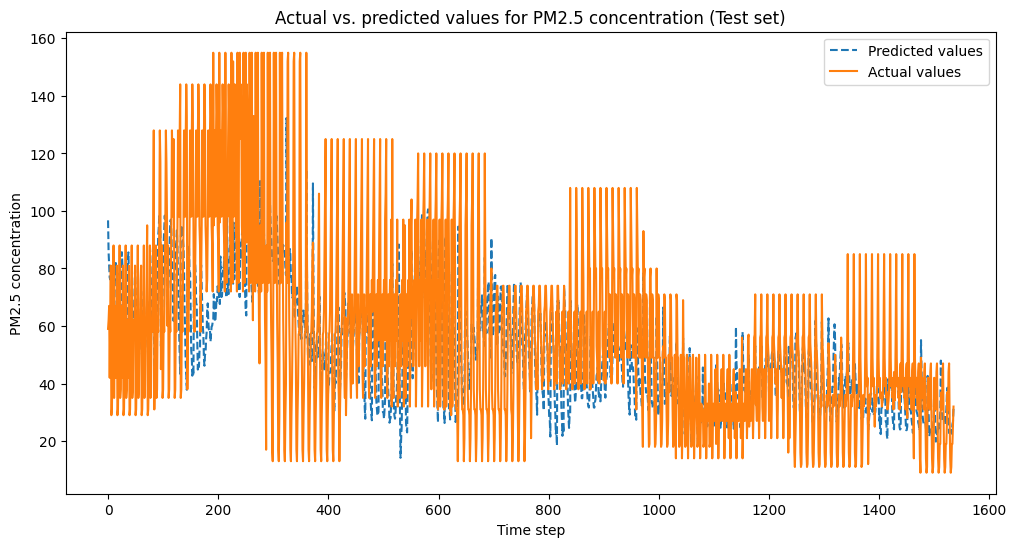

In [16]:
# 计算预测值的RMSE
rmse = np.sqrt(mean_squared_error(multistep_test_y.reshape(-1), y_pred_multistep.reshape(-1)))
print(f"RMSE: {rmse}")

# 创建一个折线图，显示实际值和预测值
plt.figure(figsize=(12, 6))
plt.plot(y_pred_multistep.reshape(-1), label="Predicted values", linestyle="--")
plt.plot(multistep_test_y.reshape(-1), label="Actual values", linestyle="-")
plt.xlabel("Time step")
plt.ylabel("PM2.5 concentration")
plt.legend()
plt.title("Actual vs. predicted values for PM2.5 concentration (Test set)")
plt.show()

In [17]:
# 获取最后一对实际值和预测值
last_actual_value = multistep_test_y[-1]
last_predicted_value = y_pred_multistep[-1]

# 计算这两个值之间的RMSE
last_rmse = np.sqrt(mean_squared_error(last_actual_value.reshape(-1), last_predicted_value.reshape(-1)))
print(f"RMSE of the last actual and predicted values: {last_rmse}")


RMSE of the last actual and predicted values: 10.99913789721874


Last actual values array:  [37. 31. 44. 47. 28. 14.  9. 11. 19. 19. 26. 32.]
Last predicted values array:  [38.54479  31.702053 27.193956 22.784958 23.124083 23.490948 23.83627
 24.597582 22.56961  25.90398  26.687832 31.417042]


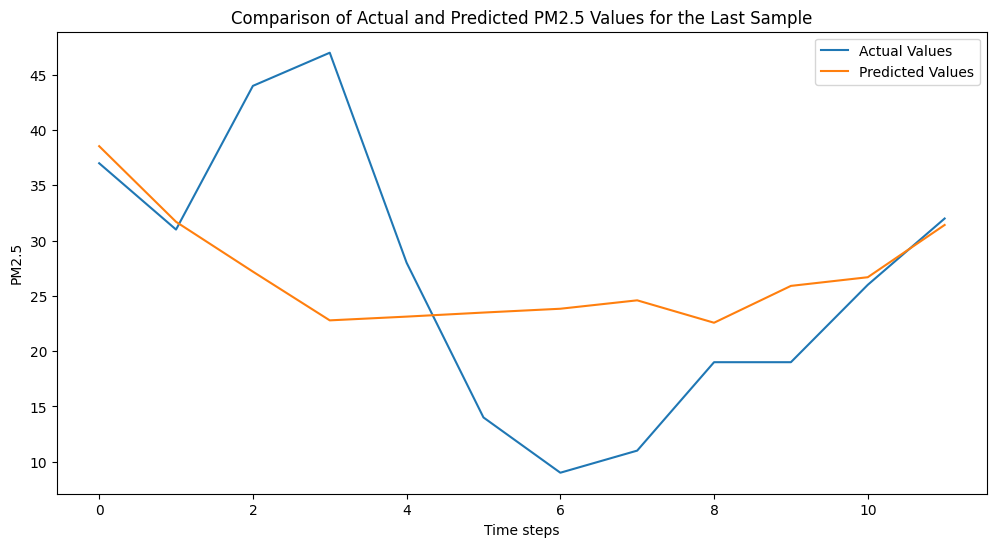

In [18]:
# 获取最后一对实际值和预测值数组
last_actual_values = multistep_test_y[-1]
last_predicted_values = y_pred_multistep[-1]

# 展示实际值和预测值数组
print("Last actual values array: ", last_actual_values)
print("Last predicted values array: ", last_predicted_values)

# 可视化实际值和预测值数组
plt.figure(figsize=(12, 6))
plt.plot(last_actual_values, label="Actual Values")
plt.plot(last_predicted_values, label="Predicted Values")
plt.xlabel("Time steps")
plt.ylabel("PM2.5")
plt.title("Comparison of Actual and Predicted PM2.5 Values for the Last Sample")
plt.legend()
plt.show()


RMSE for 3-step, 5-step, 7-step, and 12-step predictions: [28.519965408316494, 29.332580634058708, 31.11395881513182, 32.45183089875555]


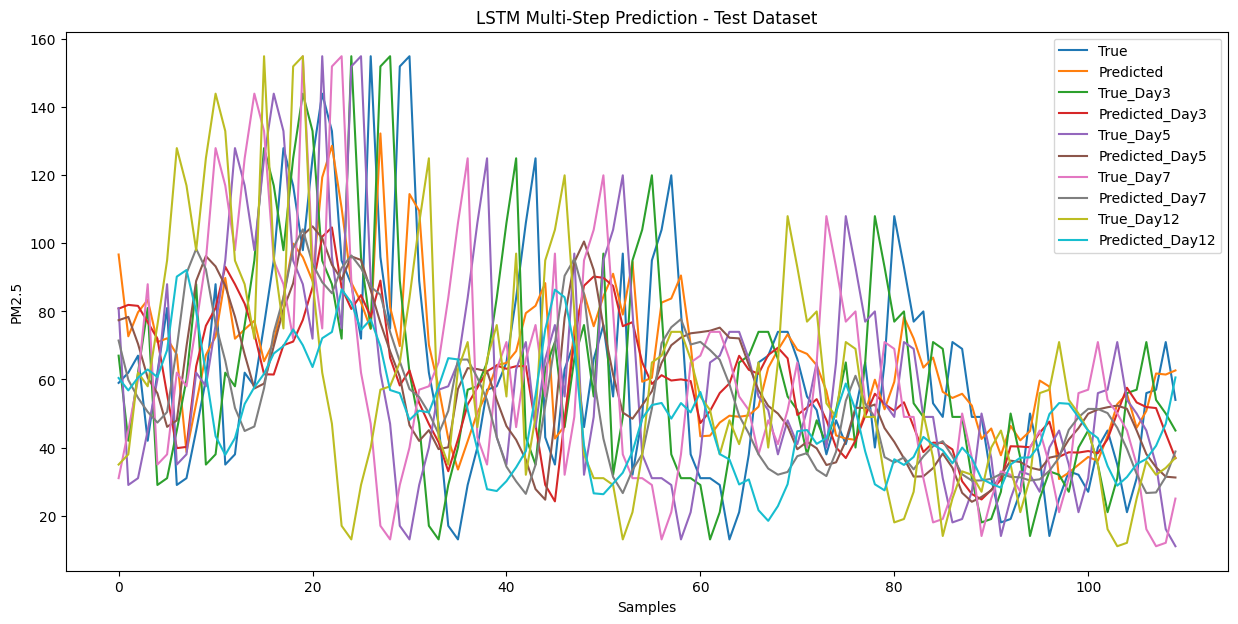

In [19]:
def evaluate_multistep_rmse(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return rmse

def predict_multistep(model, X_test, num_steps):
    y_pred = model.predict(X_test)
    return y_pred[:, :num_steps]

# 计算3步、5步、7步、12步预测的RMSE
steps_to_evaluate = [3, 5, 7, 12]
rmses = []

#y_pred_multistep = predict_multistep(model, multistep_test_x, num_steps)
right_side = 110
for num_steps in steps_to_evaluate:   
    rmse = evaluate_multistep_rmse(multistep_test_y[:right_side, num_steps-1], y_pred_multistep[:right_side, num_steps-1])
    rmses.append(rmse)

print("RMSE for 3-step, 5-step, 7-step, and 12-step predictions:", rmses)

# 可视化预测结果
plt.figure(figsize=(15, 7))
plt.plot(range(len(multistep_test_y[:110, 0])), multistep_test_y[:110, 0], label="True")
plt.plot(range(len(y_pred_multistep[:110, 0])), y_pred_multistep[:110, 0], label="Predicted")
plt.plot(range(len(multistep_test_y[:110, 2])), multistep_test_y[:110, 2], label="True_Day3")
plt.plot(range(len(y_pred_multistep[:110, 2])), y_pred_multistep[:110, 2], label="Predicted_Day3")
plt.plot(range(len(multistep_test_y[:110, 0])), multistep_test_y[:110, 5], label="True_Day5")
plt.plot(range(len(y_pred_multistep[:110, 0])), y_pred_multistep[:110, 5], label="Predicted_Day5")
plt.plot(range(len(multistep_test_y[:110, 0])), multistep_test_y[:110, 7], label="True_Day7")
plt.plot(range(len(y_pred_multistep[:110, 0])), y_pred_multistep[:110, 7], label="Predicted_Day7")
plt.plot(range(len(multistep_test_y[:110, 0])), multistep_test_y[:110, 11], label="True_Day12")
plt.plot(range(len(y_pred_multistep[:110, 0])), y_pred_multistep[:110, 11], label="Predicted_Day12")
plt.xlabel("Samples")
plt.ylabel("PM2.5")
plt.title("LSTM Multi-Step Prediction - Test Dataset")
plt.legend()
plt.show()


In [20]:
# 获取最后look_back行数据作为输入
last_rows = imputed_data_df.values[-multistep_look_back:, :]

# 调整输入数据的形状，以适应模型的输入要求
last_rows_reshaped = last_rows.reshape(1, multistep_look_back, multistep_train_x.shape[2])

# 使用模型进行预测
ques2_prediction = multistep_model.predict(last_rows_reshaped)

ques2_prediction = scaler_y.inverse_transform(ques2_prediction)
# 打印预测结果
print("预测结果:")
print(ques2_prediction)

1/1 [==============================] - 0s 111ms/step
预测结果:
[[47.74236  48.614105 49.893127 43.464863 40.78722  37.195824 30.365314
  23.152891 21.128757 22.402805 27.999767 34.861958]]


In [21]:
# 读取Excel文件
#vmd_data = pd.read_excel('3000fixed.xlsx', engine='openpyxl',)
#vmd_data = pd.read_excel('3000fixed8.xlsx', engine='openpyxl',)
#vmd_data = pd.read_excel('3000fixed7.xlsx', engine='openpyxl',)
#vmd_data = pd.read_excel('3000fixed6.xlsx', engine='openpyxl',)
#vmd_data = pd.read_excel('3000fixed5.xlsx', engine='openpyxl',)
#vmd_data = pd.read_excel('3000fixed4.xlsx', engine='openpyxl',)
vmd_data = pd.read_excel('3000fixed3.xlsx', engine='openpyxl',)
# 划分训练集和测试集
vmd_train, vmd_test = train_test_split(vmd_data, test_size=0.05, shuffle=False)

num_k = 3

# 创建一个包含10个独立LSTM模型的列表
models = [Sequential() for _ in range(num_k)]

In [22]:
def create_multistep_vmd_targets(data, look_back, num_steps):
    data_y = []
    for i in range(len(data) - look_back - num_steps):
        data_y.append(data[i + look_back:i + look_back + num_steps])
    return np.array(data_y)

In [23]:
# 对 VMD 分量进行归一化
vmd_train_normalized = vmd_train.copy()
vmd_test_normalized = vmd_test.copy()

scalers = []
for i in range(num_k):
    train_target = vmd_train.iloc[:, i].values.reshape(-1, 1)
    test_target = vmd_test.iloc[:, i].values.reshape(-1, 1)

    scaler = MinMaxScaler(feature_range=(0, 1))
    vmd_train_normalized.iloc[:, i] = scaler.fit_transform(train_target).flatten()
    vmd_test_normalized.iloc[:, i] = scaler.transform(test_target).flatten()
    scalers.append(scaler)

# 训练每个模型
for i in range(num_k):
    # 从归一化的训练集中提取目标列
    vmd_multistep_train_y = create_multistep_vmd_targets(vmd_train_normalized.iloc[:, i].values, multistep_look_back, num_steps)
    vmd_multistep_test_y = create_multistep_vmd_targets(vmd_test_normalized.iloc[:, i].values, multistep_look_back, num_steps)

    # 创建LSTM模型
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(multistep_look_back, multistep_train_x.shape[2])))
    model.add(Dense(num_steps))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

    # 训练模型
    model.fit(multistep_train_x, vmd_multistep_train_y, epochs=100, batch_size=32, verbose=1)

    # 将训练好的模型添加到模型列表中
    models[i] = model

# 预测
y_preds = [model.predict(multistep_test_x) for model in models]

# 逆归一化每个模型的预测值
y_preds_inversed = []
for i in range(num_k):
    y_preds_inversed.append(scalers[i].inverse_transform(y_preds[i]))

# 将10个模型的预测值相加，得到最终的PM2.5预测值
y_pred_combined = np.sum(y_preds_inversed, axis=0)

# 计算每个预测时间步长的 RMSE
rmse_per_step = []
for i in range(num_steps):
    rmse = np.sqrt(mean_squared_error(multistep_test_y[:, i], y_pred_combined[:, i]))
    rmse_per_step.append(rmse)

# 打印每个预测时间步长的 RMSE
for i, rmse in enumerate(rmse_per_step, start=1):
    print(f"RMSE for step {i}: {rmse:.2f}")


Epoch 1/100
90/90 [==============================] - 1s 3ms/step - loss: 0.0467
Epoch 2/100
90/90 [==============================] - 0s 3ms/step - loss: 0.0084
Epoch 3/100
90/90 [==============================] - 0s 3ms/step - loss: 0.0072
Epoch 4/100
90/90 [==============================] - 0s 3ms/step - loss: 0.0068
Epoch 5/100
90/90 [==============================] - 0s 3ms/step - loss: 0.0065
Epoch 6/100
90/90 [==============================] - 0s 3ms/step - loss: 0.0064
Epoch 7/100
90/90 [==============================] - 0s 3ms/step - loss: 0.0064
Epoch 8/100
90/90 [==============================] - 0s 3ms/step - loss: 0.0063
Epoch 9/100
90/90 [==============================] - 0s 3ms/step - loss: 0.0064
Epoch 10/100
90/90 [==============================] - 0s 3ms/step - loss: 0.0063
Epoch 11/100
90/90 [==============================] - 0s 3ms/step - loss: 0.0063
Epoch 12/100
90/90 [==============================] - 0s 3ms/step - loss: 0.0063
Epoch 13/100
90/90 [=================

90/90 [==============================] - 0s 3ms/step - loss: 0.0074
Epoch 3/100
90/90 [==============================] - 0s 3ms/step - loss: 0.0062
Epoch 4/100
90/90 [==============================] - 0s 3ms/step - loss: 0.0058
Epoch 5/100
90/90 [==============================] - 0s 3ms/step - loss: 0.0057
Epoch 6/100
90/90 [==============================] - 0s 3ms/step - loss: 0.0056
Epoch 7/100
90/90 [==============================] - 0s 3ms/step - loss: 0.0055
Epoch 8/100
90/90 [==============================] - 0s 3ms/step - loss: 0.0055
Epoch 9/100
90/90 [==============================] - 0s 3ms/step - loss: 0.0054
Epoch 10/100
90/90 [==============================] - 0s 3ms/step - loss: 0.0054
Epoch 11/100
90/90 [==============================] - 0s 3ms/step - loss: 0.0053
Epoch 12/100
90/90 [==============================] - 0s 3ms/step - loss: 0.0053
Epoch 13/100
90/90 [==============================] - 0s 3ms/step - loss: 0.0052
Epoch 14/100
90/90 [============================

90/90 [==============================] - 0s 3ms/step - loss: 0.0067
Epoch 4/100
90/90 [==============================] - 0s 2ms/step - loss: 0.0059
Epoch 5/100
90/90 [==============================] - 0s 3ms/step - loss: 0.0056
Epoch 6/100
90/90 [==============================] - 0s 3ms/step - loss: 0.0051
Epoch 7/100
90/90 [==============================] - 0s 3ms/step - loss: 0.0049
Epoch 8/100
90/90 [==============================] - 0s 4ms/step - loss: 0.0050
Epoch 9/100
90/90 [==============================] - 0s 3ms/step - loss: 0.0049
Epoch 10/100
90/90 [==============================] - 0s 3ms/step - loss: 0.0047
Epoch 11/100
90/90 [==============================] - 0s 3ms/step - loss: 0.0046
Epoch 12/100
90/90 [==============================] - 0s 3ms/step - loss: 0.0046
Epoch 13/100
90/90 [==============================] - 0s 3ms/step - loss: 0.0045
Epoch 14/100
90/90 [==============================] - 0s 3ms/step - loss: 0.0046
Epoch 15/100
90/90 [===========================

4/4 [==============================] - 0s 2ms/step
RMSE for step 1: 32.39
RMSE for step 2: 35.10
RMSE for step 3: 36.57
RMSE for step 4: 35.19
RMSE for step 5: 36.42
RMSE for step 6: 36.37
RMSE for step 7: 36.68
RMSE for step 8: 38.57
RMSE for step 9: 39.08
RMSE for step 10: 38.45
RMSE for step 11: 39.83
RMSE for step 12: 41.20


In [24]:
# 转换为 NumPy 数组并堆叠
y_preds_stacked = np.stack(y_preds, axis=0)

# 逆归一化每个波的预测值
y_preds_inversed = []
for i in range(num_k):
    train_target = vmd_train.iloc[:, i].values.reshape(-1, 1)
    scaler_y = MinMaxScaler(feature_range=(0, 1))
    scaler_y.fit_transform(train_target)
    y_preds_inversed.append(scaler_y.inverse_transform(y_preds_stacked[i].T))

# 转换为 NumPy 数组并堆叠
y_preds_inversed_stacked = np.stack(y_preds_inversed, axis=0)

# 将10个波的预测值相加，得到最终的PM2.5预测值
y_pred_combined = np.sum(y_preds_inversed_stacked, axis=0)

# 评估预测结果
# ...


In [25]:
print(y_pred_combined)
print(y_pred_combined.shape[0])

[[ 57.42324     15.101452    17.012947   ...  -1.3906403   27.420145
   43.483982  ]
 [ 24.295633    24.08628     42.06169    ...  32.230064    54.606094
    8.600195  ]
 [ 17.732597    41.872093    33.174824   ...  51.488754     8.5032425
  -17.86475   ]
 ...
 [ 37.2285      42.119602    51.802307   ...  43.802307    56.031822
   -0.34719658]
 [ 33.873997    46.228107    28.091423   ...  56.456573     3.4029388
  -15.9708805 ]
 [ 36.277565    18.653023    -1.0777168  ...   7.068775   -12.403366
   21.935673  ]]
12


In [26]:
# 逆归一化每个模型的预测值
y_preds_inversed = []
for i in range(num_k):
    train_target = vmd_train.iloc[:, i].values.reshape(-1, 1)
    scaler_y = MinMaxScaler(feature_range=(0, 1))
    scaler_y.fit_transform(train_target)
    y_preds_inversed.append(scaler_y.inverse_transform(y_preds[i]))

# 打印一些逆归一化的预测值以进行调试
for i in range(3):
    print(f"Model {i + 1} inverse transformed predictions:")
    print(y_preds_inversed[i][:3])

# 将10个模型的预测值相加，得到最终的PM2.5预测值
y_pred_combined = np.sum(y_preds_inversed, axis=0)

# 打印一些相加后的预测值以进行调试
print("Combined predictions:")
print(y_pred_combined[:3])

# 计算每个预测时间步长的 RMSE
rmse_per_step = []
for i in range(num_steps):
    rmse = np.sqrt(mean_squared_error(multistep_test_y[:, i], y_pred_combined[:, i]))
    rmse_per_step.append(rmse)

# 打印每个预测时间步长的 RMSE
for i, rmse in enumerate(rmse_per_step, start=1):
    print(f"RMSE for step {i}: {rmse:.2f}")


Model 1 inverse transformed predictions:
[[  8.864598  -13.582545  -10.204812   15.184645    7.351275  -12.391303
   -6.1417966  13.016636    5.2214594 -12.572642   -4.190249   10.7046585]
 [-16.235405   -1.070814   19.716835    5.2061176 -19.26342    -1.9764767
   19.798454    5.9548235 -15.479068   -1.4463525  18.072603    3.2868505]
 [ -8.842603   17.029299    7.2924705 -15.321936   -7.546867   15.39627
    6.5643063 -17.538742   -3.820107   17.257572    6.651166  -14.553244 ]]
Model 2 inverse transformed predictions:
[[  2.3155222  -6.1429048 -15.160877  -12.38923    -7.455092    3.7740517
   16.097052   20.997665   22.875504   13.590669    1.9828176  -9.776567 ]
 [-13.299251  -18.406805  -20.560534   -9.171832    3.6928387  17.716074
   27.695755   26.021969   19.478046    6.605376   -9.163989  -21.135143 ]
 [-17.409966  -17.36      -15.366022   -4.398774    9.248396   19.482998
   25.693384   19.116056   10.406081   -1.9951309 -14.842863  -22.695179 ]]
Model 3 inverse transformed

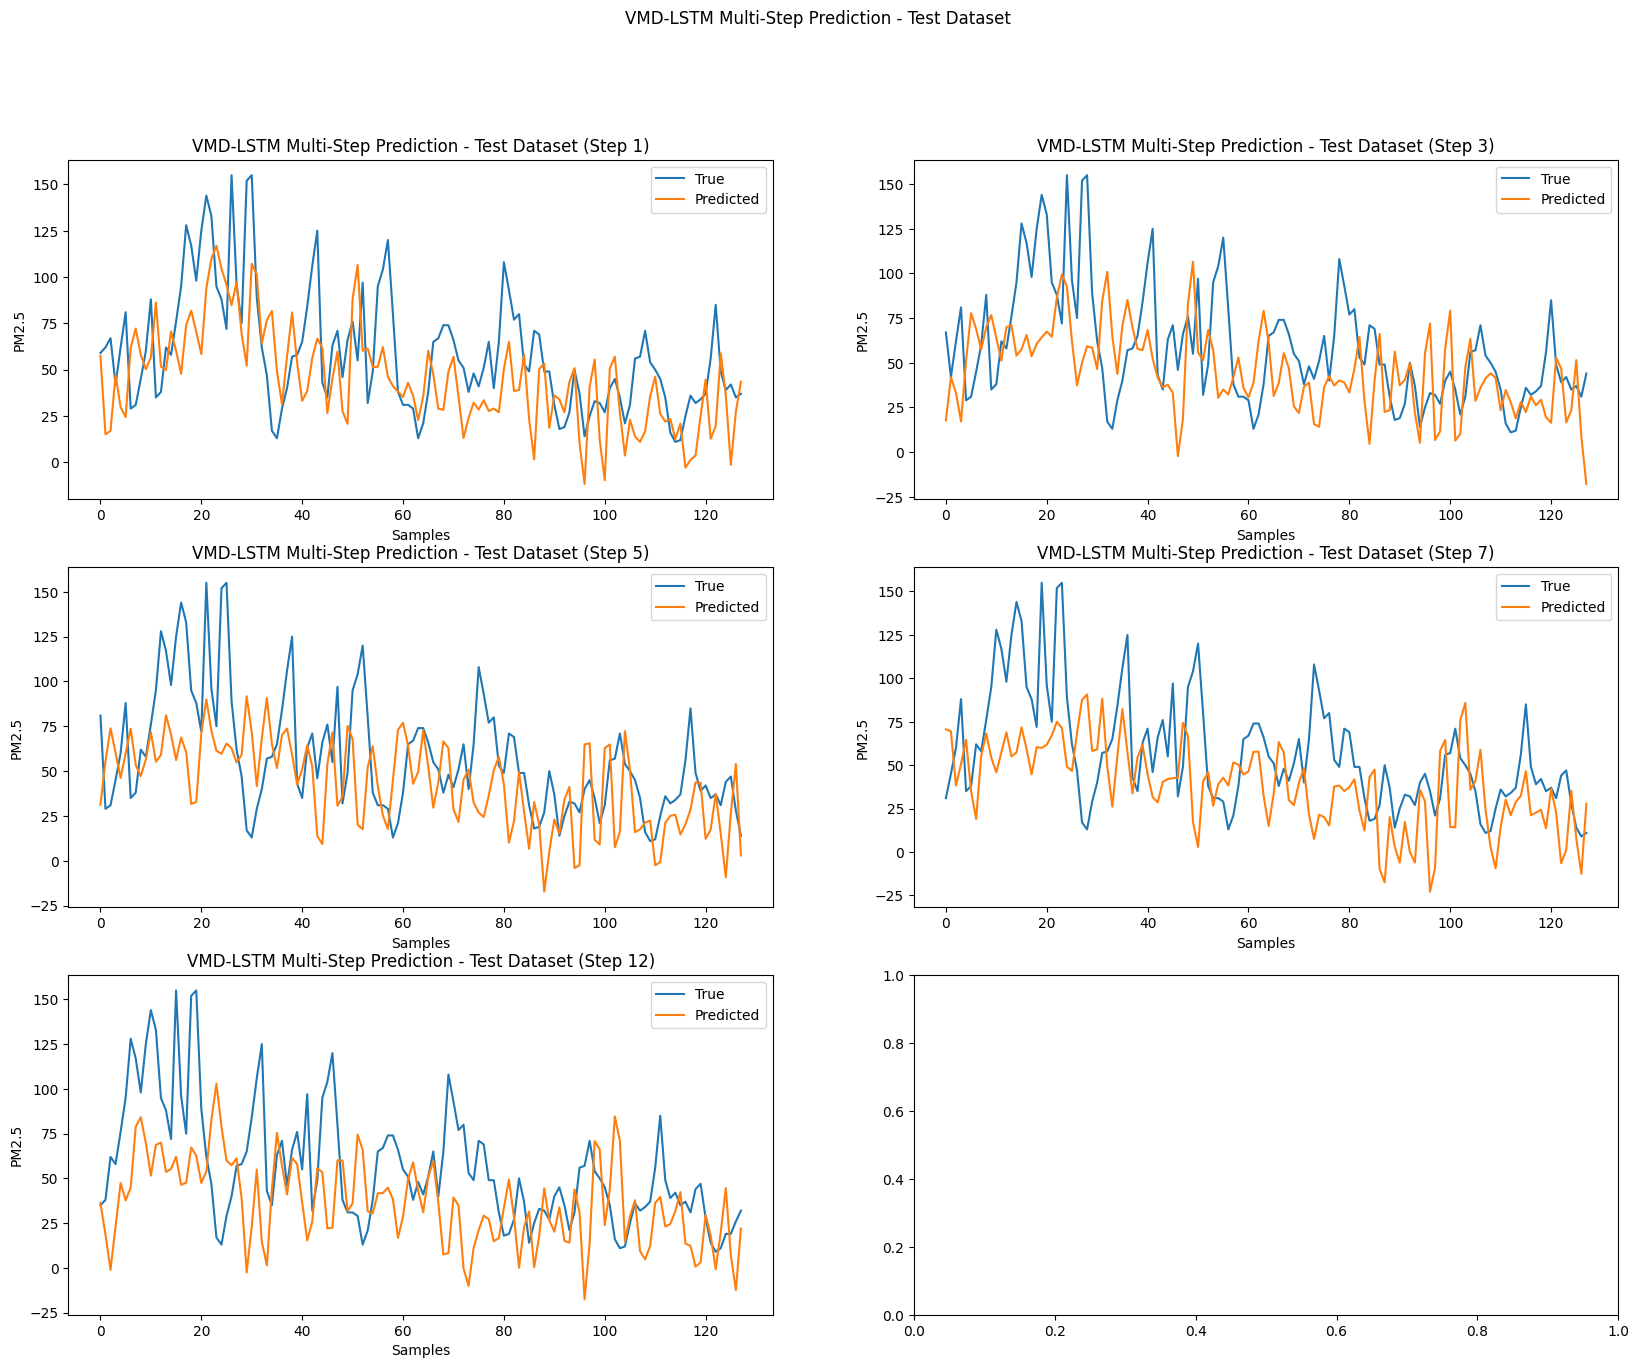

In [27]:
# 可视化预测结果
fig, axs = plt.subplots(3, 2, figsize=(20, 15))
axs[0, 0].plot(range(len(multistep_test_y[:, 0])), multistep_test_y[:, 0], label="True")
axs[0, 0].plot(range(len(y_pred_combined[:, 0])), y_pred_combined[:, 0], label="Predicted")
axs[0, 0].set_xlabel("Samples")
axs[0, 0].set_ylabel("PM2.5")
axs[0, 0].set_title("VMD-LSTM Multi-Step Prediction - Test Dataset (Step 1)")
axs[0, 0].legend()

axs[0, 1].plot(range(len(multistep_test_y[:, 2])), multistep_test_y[:, 2], label="True")
axs[0, 1].plot(range(len(y_pred_combined[:, 2])), y_pred_combined[:, 2], label="Predicted")
axs[0, 1].set_xlabel("Samples")
axs[0, 1].set_ylabel("PM2.5")
axs[0, 1].set_title("VMD-LSTM Multi-Step Prediction - Test Dataset (Step 3)")
axs[0, 1].legend()

axs[1, 0].plot(range(len(multistep_test_y[:, 5])), multistep_test_y[:, 5], label="True")
axs[1, 0].plot(range(len(y_pred_combined[:, 5])), y_pred_combined[:, 5], label="Predicted")
axs[1, 0].set_xlabel("Samples")
axs[1, 0].set_ylabel("PM2.5")
axs[1, 0].set_title("VMD-LSTM Multi-Step Prediction - Test Dataset (Step 5)")
axs[1, 0].legend()

axs[1, 1].plot(range(len(multistep_test_y[:, 7])), multistep_test_y[:, 7], label="True")
axs[1, 1].plot(range(len(y_pred_combined[:, 7])), y_pred_combined[:, 7], label="Predicted")
axs[1, 1].set_xlabel("Samples")
axs[1, 1].set_ylabel("PM2.5")
axs[1, 1].set_title("VMD-LSTM Multi-Step Prediction - Test Dataset (Step 7)")
axs[1, 1].legend()

axs[2, 0].plot(range(len(multistep_test_y[:, 11])), multistep_test_y[:, 11], label="True")
axs[2, 0].plot(range(len(y_pred_combined[:, 11])), y_pred_combined[:, 11], label="Predicted")
axs[2, 0].set_xlabel("Samples")
axs[2, 0].set_ylabel("PM2.5")
axs[2, 0].set_title("VMD-LSTM Multi-Step Prediction - Test Dataset (Step 12)")
axs[2, 0].legend()

plt.suptitle("VMD-LSTM Multi-Step Prediction - Test Dataset")
plt.show()


In [28]:
# 预测
ques2_y_preds = [model.predict(last_rows_reshaped) for model in models]

# 逆归一化每个模型的预测值
y_preds_inversed = []
for i in range(num_k):
    y_preds_inversed.append(scalers[i].inverse_transform(ques2_y_preds[i]))

# 将10个模型的预测值相加，得到最终的PM2.5预测值
y_pred_combined = np.sum(y_preds_inversed, axis=0)
print(y_pred_combined)
print(y_pred_combined.shape[0])

1/1 [==============================] - 0s 115ms/step
[[40.535404 36.673447 31.665325 35.37104  29.577599 29.791677 31.33242
  18.602856 24.771273 19.075792 16.973686 19.382689]]
1


# 第三小问

In [29]:
# 特征列的索引，假设PM10、SO2、NO2、CO、O3分别是第0、1、2、3、4列
feature_indices = [4, 5, 6, 8, 9]

data_train_multivar, data_test_multivar = train_test_split(imputed_data_df_static, test_size=0.1, shuffle=False)

multivar_train_x, multivar_train_y = create_multistep_dataset(data_train_multivar, multistep_look_back, num_steps)
multivar_test_x, multivar_test_y = create_multistep_dataset(data_test_multivar, multistep_look_back, num_steps)

# 创建一个字典，用于存储每个特征的模型
feature_models = {}

for index in feature_indices:
    # 为每个特征创建训练数据和测试数据
    multivar_train_y_feature = multivar_train_y[:, index]
    multivar_test_y_feature = multivar_test_y[:, index]

    # 创建并训练模型
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(multistep_look_back, multivar_train_x.shape[2])))
    model.add(Dense(num_steps))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    model.fit(multivar_train_x, multivar_train_y_feature, epochs=100, batch_size=32, verbose=1)

    # 将训练好的模型添加到字典中
    feature_models[index] = model

Epoch 1/100
85/85 [==============================] - 1s 3ms/step - loss: 0.0552
Epoch 2/100
85/85 [==============================] - 0s 4ms/step - loss: 0.0286
Epoch 3/100
85/85 [==============================] - 0s 3ms/step - loss: 0.0263
Epoch 4/100
85/85 [==============================] - 0s 3ms/step - loss: 0.0258
Epoch 5/100
85/85 [==============================] - 0s 3ms/step - loss: 0.0253
Epoch 6/100
85/85 [==============================] - 0s 4ms/step - loss: 0.0250
Epoch 7/100
85/85 [==============================] - 0s 4ms/step - loss: 0.0248
Epoch 8/100
85/85 [==============================] - 0s 4ms/step - loss: 0.0245
Epoch 9/100
85/85 [==============================] - 0s 3ms/step - loss: 0.0246
Epoch 10/100
85/85 [==============================] - 0s 3ms/step - loss: 0.0242
Epoch 11/100
85/85 [==============================] - 0s 3ms/step - loss: 0.0238
Epoch 12/100
85/85 [==============================] - 0s 3ms/step - loss: 0.0234
Epoch 13/100
85/85 [=================

85/85 [==============================] - 0s 3ms/step - loss: 0.0283
Epoch 3/100
85/85 [==============================] - 0s 4ms/step - loss: 0.0264
Epoch 4/100
85/85 [==============================] - 0s 3ms/step - loss: 0.0263
Epoch 5/100
85/85 [==============================] - 0s 3ms/step - loss: 0.0259
Epoch 6/100
85/85 [==============================] - 0s 3ms/step - loss: 0.0255
Epoch 7/100
85/85 [==============================] - 0s 3ms/step - loss: 0.0253
Epoch 8/100
85/85 [==============================] - 0s 3ms/step - loss: 0.0248
Epoch 9/100
85/85 [==============================] - 0s 3ms/step - loss: 0.0249
Epoch 10/100
85/85 [==============================] - 0s 3ms/step - loss: 0.0246
Epoch 11/100
85/85 [==============================] - 0s 3ms/step - loss: 0.0244
Epoch 12/100
85/85 [==============================] - 0s 3ms/step - loss: 0.0240
Epoch 13/100
85/85 [==============================] - 0s 4ms/step - loss: 0.0239
Epoch 14/100
85/85 [============================

85/85 [==============================] - 0s 3ms/step - loss: 0.0268
Epoch 4/100
85/85 [==============================] - 0s 3ms/step - loss: 0.0261
Epoch 5/100
85/85 [==============================] - 0s 2ms/step - loss: 0.0262
Epoch 6/100
85/85 [==============================] - 0s 3ms/step - loss: 0.0258
Epoch 7/100
85/85 [==============================] - 0s 3ms/step - loss: 0.0256
Epoch 8/100
85/85 [==============================] - 0s 3ms/step - loss: 0.0255
Epoch 9/100
85/85 [==============================] - 0s 3ms/step - loss: 0.0257
Epoch 10/100
85/85 [==============================] - 0s 3ms/step - loss: 0.0252
Epoch 11/100
85/85 [==============================] - 0s 3ms/step - loss: 0.0256
Epoch 12/100
85/85 [==============================] - 0s 3ms/step - loss: 0.0251
Epoch 13/100
85/85 [==============================] - 0s 3ms/step - loss: 0.0249
Epoch 14/100
85/85 [==============================] - 0s 3ms/step - loss: 0.0250
Epoch 15/100
85/85 [===========================

85/85 [==============================] - 0s 3ms/step - loss: 0.0265
Epoch 5/100
85/85 [==============================] - 0s 3ms/step - loss: 0.0262
Epoch 6/100
85/85 [==============================] - 0s 3ms/step - loss: 0.0267
Epoch 7/100
85/85 [==============================] - 0s 3ms/step - loss: 0.0260
Epoch 8/100
85/85 [==============================] - 0s 3ms/step - loss: 0.0259
Epoch 9/100
85/85 [==============================] - 0s 3ms/step - loss: 0.0259
Epoch 10/100
85/85 [==============================] - 0s 3ms/step - loss: 0.0259
Epoch 11/100
85/85 [==============================] - 0s 3ms/step - loss: 0.0255
Epoch 12/100
85/85 [==============================] - 0s 3ms/step - loss: 0.0257
Epoch 13/100
85/85 [==============================] - 0s 3ms/step - loss: 0.0255
Epoch 14/100
85/85 [==============================] - 0s 3ms/step - loss: 0.0255
Epoch 15/100
85/85 [==============================] - 0s 3ms/step - loss: 0.0251
Epoch 16/100
85/85 [==========================

85/85 [==============================] - 0s 2ms/step - loss: 0.0268
Epoch 6/100
85/85 [==============================] - 0s 2ms/step - loss: 0.0262
Epoch 7/100
85/85 [==============================] - 0s 2ms/step - loss: 0.0263
Epoch 8/100
85/85 [==============================] - 0s 2ms/step - loss: 0.0262
Epoch 9/100
85/85 [==============================] - 0s 2ms/step - loss: 0.0260
Epoch 10/100
85/85 [==============================] - 0s 3ms/step - loss: 0.0258
Epoch 11/100
85/85 [==============================] - 0s 3ms/step - loss: 0.0262
Epoch 12/100
85/85 [==============================] - 0s 3ms/step - loss: 0.0255
Epoch 13/100
85/85 [==============================] - 0s 5ms/step - loss: 0.0256
Epoch 14/100
85/85 [==============================] - 0s 4ms/step - loss: 0.0259
Epoch 15/100
85/85 [==============================] - 0s 3ms/step - loss: 0.0255
Epoch 16/100
85/85 [==============================] - 0s 3ms/step - loss: 0.0252
Epoch 17/100
85/85 [=========================

In [30]:
# 获取最后look_back行数据作为输入
last_rows = imputed_data_df_static[-multistep_look_back:, :]

# 调整输入数据的形状，以适应模型的输入要求
last_rows_reshaped = last_rows.reshape(1, multistep_look_back, multivar_train_x.shape[2])

# 使用模型进行预测
feature_predictions = {}
for index, model in feature_models.items():
    every_prediction = model.predict(last_rows_reshaped)

    # 创建一个临时数组，形状与原始数据相同
    temp_array = np.zeros((every_prediction.shape[0], every_prediction.shape[1], imputed_data_df_static.shape[1]))

    # 将预测值插入到临时数组中的相应位置
    temp_array[:, :, index] = every_prediction

    # 逆归一化预测值
    inverse_transformed = scaler_all.inverse_transform(temp_array.reshape(-1, imputed_data_df_static.shape[1]))
    inverse_transformed = inverse_transformed.reshape(every_prediction.shape[0], every_prediction.shape[1], imputed_data_df_static.shape[1])

    # 提取我们关心的特征
    feature_predictions[index] = inverse_transformed[:, :, index]

1/1 [==============================] - 0s 115ms/step


In [31]:
print(feature_predictions)

{4: array([[58.8327194 , 59.56682796, 59.94890153, 61.97120113, 56.66596637,
        59.01070946, 63.05254164, 60.62853344, 61.56514866, 60.41976773,
        57.50708888, 60.6825328 ]]), 5: array([[84.2492807 , 87.93280794, 88.07405095, 86.8229132 , 86.00622055,
        89.60785861, 86.2489829 , 82.64508689, 85.27015939, 85.67803868,
        87.0218405 , 84.07683095]]), 6: array([[13.5184844 , 13.30384266, 13.31177569, 14.17967402, 13.67104391,
        13.18844983, 13.60197105, 13.14463954, 13.63976975, 13.55575897,
        13.33341521, 13.37594116]]), 8: array([[24.35428892, 23.89363786, 23.89997422, 24.61127602, 23.59957569,
        24.1306204 , 24.63151135, 24.40636975, 23.84489492, 24.13484509,
        24.11316352, 23.86932139]]), 9: array([[0.80250351, 0.81193744, 0.79870269, 0.82921204, 0.81989599,
        0.82022349, 0.83553429, 0.8204079 , 0.8237286 , 0.82296339,
        0.81512378, 0.81579678]])}


feature_predictions.to_csv("feature_predictions.csv", index=False, encoding="utf-8")

print(feature_predictions.keys())

In [32]:
# 计算AQI
for i in range(num_steps):
    # 获取第i天的各个特征预测值
    PM10 = feature_predictions[4][0][i]
    O3 = feature_predictions[5][0][i]
    SO2 = feature_predictions[6][0][i]
    NO2 = feature_predictions[8][0][i]
    C0 = feature_predictions[9][0][i]

def calculate_aqi(data):
    def _iaqi_(IHI, ILO, BHI, BLO, C):
        return ((IHI - ILO) / (BHI - BLO)) * (C - BLO) + ILO

    def get_breakpoint_(breakpoints, C):
        for i in range(len(breakpoints)):
            IHI, ILO, BHI, BLO = breakpoints[i]
            if C >= BLO and C <= BHI:
                return IHI, ILO, BHI, BLO
        raise ValueError("Pollutant concentration out of range")

    # AQI breakpoints for each pollutant
    breakpoints = [
        # PM2.5
        (50, 0, 35, 0),
        (100, 50, 75, 35),
        (150, 100, 115, 75),
        (200, 150, 150, 115),
        (300, 200, 250, 150),
        (400, 300, 350, 250),
        (500, 400, 500, 350),
        # PM10
        (50, 0, 50, 0),
        (100, 50, 150, 50),
        (150, 100, 250, 150),
        (200, 150, 350, 250),
        (300, 200, 420, 350),
        (400, 300, 500, 420),
        (500, 400, 600, 500),
        # SO2
        (50, 0, 50, 0),
        (100, 50, 150, 50),
        (150, 100, 475, 150),
        (200, 150, 800, 475),
        (300, 200, 1600, 800),
        (400, 300, 2100, 1600),
        (500, 400, 2620, 2100),
        # NO2
        (50, 0, 40, 0),
        (100, 50, 80, 40),
        (150, 100, 180, 80),
        (200, 150, 280, 180),
        (300, 200, 565, 280),
        (400, 300, 750, 565),
        (500, 400, 940, 750),
        # CO
        (50, 0, 2, 0),
        (100, 50, 4, 2),
        (150, 100, 14, 4),
        (200, 150, 24, 14),
        (300, 200, 36, 24),
        (400, 300, 48, 36),
        (500, 400, 60, 48),
        # O3
        (50, 0, 100, 0),
        (100, 50, 160, 100),
        (150, 100, 215, 160),
        (200, 150, 265, 215),
        (300, 200, 800, 265),
        (400, 300, 800, 800),
        (500, 400, 800, 800),
    ]


    aqi_values = []
    for d in data:
        PM10_i = _iaqi_(*get_breakpoint_(breakpoints[7:14], d[0]), d[0])
        SO2_i = _iaqi_(*get_breakpoint_(breakpoints[14:21], d[1]), d[1])
        NO2_i = _iaqi_(*get_breakpoint_(breakpoints[21:28], d[2]), d[2])
        CO_i = _iaqi_(*get_breakpoint_(breakpoints[28:35], d[3]), d[3])
        O3_i = _iaqi_(*get_breakpoint_(breakpoints[35:], d[4]), d[4])
        AQI = round(max(PM10_i, SO2_i, NO2_i, CO_i, O3_i))
        aqi_values.append(AQI)

    return aqi_values


# 提取预测值中的 PM10, SO2, NO2, CO, O3
predicted_pollutants = np.zeros((12, 5))

# 确保 feature_predictions 的键按照 PM10, SO2, NO2, CO, O3 的顺序排列
ordered_keys = [4, 6, 8, 9, 5]

for i, key in enumerate(ordered_keys):
    predicted_pollutants[:, i] = feature_predictions[key].reshape(-1)

# 使用 `calculate_aqi` 函数计算未来12天的AQI值
predicted_aqi_values = calculate_aqi(predicted_pollutants)

# 输出预测的AQI值
print(predicted_aqi_values)

[54, 55, 55, 56, 53, 55, 57, 55, 56, 55, 54, 55]


评估我的预测好不好

In [43]:
def dict_calculate_aqi(data_dict):
    def _iaqi_(IHI, ILO, BHI, BLO, C):
        return ((IHI - ILO) / (BHI - BLO)) * (C - BLO) + ILO

    def get_breakpoint_(breakpoints, C):
        for i in range(len(breakpoints)):
            IHI, ILO, BHI, BLO = breakpoints[i]
            if C >= BLO and C <= BHI:
                return IHI, ILO, BHI, BLO
        raise ValueError("Pollutant concentration out of range")

    # AQI breakpoints for each pollutant
    breakpoints = [
        # PM2.5
        (50, 0, 35, 0),
        (100, 50, 75, 35),
        (150, 100, 115, 75),
        (200, 150, 150, 115),
        (300, 200, 250, 150),
        (400, 300, 350, 250),
        (500, 400, 500, 350),
        # PM10
        (50, 0, 50, 0),
        (100, 50, 150, 50),
        (150, 100, 250, 150),
        (200, 150, 350, 250),
        (300, 200, 420, 350),
        (400, 300, 500, 420),
        (500, 400, 600, 500),
        # SO2
        (50, 0, 50, 0),
        (100, 50, 150, 50),
        (150, 100, 475, 150),
        (200, 150, 800, 475),
        (300, 200, 1600, 800),
        (400, 300, 2100, 1600),
        (500, 400, 2620, 2100),
        # NO2
        (50, 0, 40, 0),
        (100, 50, 80, 40),
        (150, 100, 180, 80),
        (200, 150, 280, 180),
        (300, 200, 565, 280),
        (400, 300, 750, 565),
        (500, 400, 940, 750),
        # CO
        (50, 0, 2, 0),
        (100, 50, 4, 2),
        (150, 100, 14, 4),
        (200, 150, 24, 14),
        (300, 200, 36, 24),
        (400, 300, 48, 36),
        (500, 400, 60, 48),
        # O3
        (50, 0, 100, 0),
        (100, 50, 160, 100),
        (150, 100, 215, 160),
        (200, 150, 265, 215),
        (300, 200, 800, 265),
        (400, 300, 800, 800),
        (500, 400, 800, 800),
    ]
    aqi_values = []
    for j in range(data_dict[4].shape[0]):  # 添加外部循环以处理所有行
        row_aqi_values = []
        for i in range(data_dict[4].shape[1]):  # 原始循环现在处理每一列
            d = [
                data_dict[4][j, i],
                data_dict[6][j, i],
                data_dict[8][j, i],
                data_dict[9][j, i],
                data_dict[5][j, i],
            ]
            PM10_i = _iaqi_(*get_breakpoint_(breakpoints[7:14], d[0]), d[0])
            SO2_i = _iaqi_(*get_breakpoint_(breakpoints[14:21], d[1]), d[1])
            NO2_i = _iaqi_(*get_breakpoint_(breakpoints[21:28], d[2]), d[2])
            CO_i = _iaqi_(*get_breakpoint_(breakpoints[28:35], d[3]), d[3])
            O3_i = _iaqi_(*get_breakpoint_(breakpoints[35:], d[4]), d[4])
            AQI = round(max(PM10_i, SO2_i, NO2_i, CO_i, O3_i))
            row_aqi_values.append(AQI)
        aqi_values.append(row_aqi_values)

    return aqi_values

In [44]:
import math

# 使用训练集数据进行预测
test_feature_predictions = {}
for index, model in feature_models.items():
    test_pred = model.predict(multivar_test_x)

    # 创建一个临时数组，形状与原始数据相同
    temp_array = np.zeros((test_pred.shape[0], test_pred.shape[1], imputed_data_df_static.shape[1]))

    # 将预测值插入到临时数组中的相应位置
    temp_array[:, :, index] = test_pred

    # 逆归一化预测值
    inverse_transformed = scaler_all.inverse_transform(temp_array.reshape(-1, imputed_data_df_static.shape[1]))
    inverse_transformed = inverse_transformed.reshape(test_pred.shape[0], test_pred.shape[1], imputed_data_df_static.shape[1])

    # 提取我们关心的特征
    test_feature_predictions[index] = inverse_transformed[:, :, index]

9/9 [==============================] - 0s 2ms/step


In [45]:
# 根据预测值计算AQI
predicted_aqi_test = dict_calculate_aqi(test_feature_predictions)  # 使用你的calculate_aqi函数

In [51]:
# 计算每天的预测误差
daily_errors = []
for i in range(len(predicted_aqi_test)):
    day_pred = [predicted_aqi_test[j][i] for j in range(len(predicted_aqi_test))]
    day_actual = [multivar_test_y[j][i] for j in range(len(multivar_test_y))]
    daily_rmse = math.sqrt(mean_squared_error(day_actual, day_pred))
    print(f"第 {i+1} 天的预测误差RMSE：", daily_rmse)
    


第 1 天的预测误差RMSE： 56.20506670504335
第 2 天的预测误差RMSE： 58.13523544027902
第 3 天的预测误差RMSE： 56.90806944262918
第 4 天的预测误差RMSE： 58.65050401221469
第 5 天的预测误差RMSE： 57.727553570901044
第 6 天的预测误差RMSE： 58.14700131360103
第 7 天的预测误差RMSE： 58.55942939625486
第 8 天的预测误差RMSE： 58.98858316553808
第 9 天的预测误差RMSE： 58.228166901729345
第 10 天的预测误差RMSE： 57.77132068194315
第 11 天的预测误差RMSE： 57.17607087335963
第 12 天的预测误差RMSE： 57.83534037877181


IndexError: list index out of range